### Reconstruction with application temperature parameters to scores

In [ ]:
# Ensure necessary packages are installed
!pip install cobra efmtool numpy pandas scipy

COBRApy Definition of the SK Network from Szallasi's "A first course in Systems Biology"

In [1]:
from cobra import Model, Reaction, Metabolite

# Modell erstellen
model = Model("Simple_Network")

# Metaboliten definieren
A_EX = Metabolite("A_EX", compartment="e")
B_EX = Metabolite("B_EX", compartment="e")
P_EX = Metabolite("P_EX", compartment="e")
E_EX = Metabolite("E_EX", compartment="e")
A = Metabolite("A", compartment="c")
B = Metabolite("B", compartment="c")
C = Metabolite("C", compartment="c")
D = Metabolite("D", compartment="c")
E = Metabolite("E", compartment="c")
P = Metabolite("P", compartment="c")


# Reaktionen definieren
r1 = Reaction("A_in")
r1.name = "r1"
r1.lower_bound = 0.0
r1.upper_bound = 1000.0
r1.add_metabolites({A_EX: -1, A: 1})

r2 = Reaction("B_in_out")
r2.name = "r2"
r2.lower_bound = -1000.0
r2.upper_bound = 1000.0
r2.add_metabolites({B_EX: -1, B: 1})

r3 = Reaction("P_out")
r3.name = "r3"
r3.lower_bound = 0.0
r3.upper_bound = 1000.0
r3.add_metabolites({P: -1, P_EX: 1})

r4 = Reaction("E_out")
r4.name = "r4"
r4.lower_bound = 0.0
r4.upper_bound = 1000.0
r4.add_metabolites({E_EX: 1, E: -1})

r5 = Reaction("r5")
r5.name = "r5"
r5.lower_bound = 0.0
r5.upper_bound = 1000.0
r5.add_metabolites({A: -1, B: 1})

r6 = Reaction("r6")
r6.name = "r6"
r6.lower_bound = 0.0
r6.upper_bound = 1000.0
r6.add_metabolites({A: -1, C: 1})

r7 = Reaction("r7")
r7.name = "r7"
r7.lower_bound = 0.0
r7.upper_bound = 1000.0
r7.add_metabolites({A: -1, D: 1})

r8 = Reaction("r8")
r8.name = "r8"
r8.lower_bound = -1000.0
r8.upper_bound = 1000.0
r8.add_metabolites({B: -1, C: 1})

r9 = Reaction("r9")
r9.name = "r9"
r9.lower_bound = 0.0
r9.upper_bound = 1000.0
r9.add_metabolites({B: -1, P: 1})

r10 = Reaction("r10")
r10.name = "r10"
r10.lower_bound = 0.0
r10.upper_bound = 1000.0
r10.add_metabolites({C: -1, D: -1, P: 1, E: 1})


# Reaktionen zum Modell hinzufügen
model.add_reactions([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10])

# Modell überprüfen
print("Reaktionen:", [rxn.id for rxn in model.reactions])
print("Metaboliten:", [met.id for met in model.metabolites])
print("Gene:", [gene.id for gene in model.genes])

# Modell speichern (optional)
#model.save("simple_network.xml")


Reaktionen: ['A_in', 'B_in_out', 'P_out', 'E_out', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10']
Metaboliten: ['A_EX', 'A', 'B_EX', 'B', 'P', 'P_EX', 'E_EX', 'E', 'C', 'D']
Gene: []


In [2]:
import numpy as np
import cobra


def get_stoichiometric_matrix(model):
    # Filtere die Reaktionen, um nur Reaktionen zu behalten, die nicht mit "EX_" beginnen, also keine CobraPy-Exchange Reaktionen falls vorhanden
    internal_reactions = [rxn for rxn in model.reactions if not rxn.id.startswith("EX_")]

    # Extrahiere die Metaboliten aus dem Modell
    internal_metabolites = [meta for meta in model.metabolites if not meta.compartment == 'e']

    # Erstelle die leere Stöchiometrie-Matrix mit (Anzahl der Metaboliten, Anzahl der internen Reaktionen)
    stoichiometric_matrix = np.zeros((len(internal_metabolites), len(internal_reactions)))

    # Befülle die Stöchiometrie-Matrix so, dass jede Spalte eine Reaktion repräsentiert
    for j, rxn in enumerate(internal_reactions):  # Spaltenweise über Reaktionen iterieren
        for i, met in enumerate(internal_metabolites):  # Zeilenweise über Metaboliten iterieren
            stoichiometric_matrix[i, j] = rxn.metabolites.get(met, 0)  # Falls Metabolit nicht in der Reaktion ist, wird 0 zurückgegeben
    return stoichiometric_matrix

In [3]:
import efmtool
import cobra
import numpy as np
from efmtool import calculate_efms

def cobra_to_efms(model):
    # 1. Stoichiometric matrix (S matrix)
    metabolites = [
    metabolite for metabolite in model.metabolites 
    if metabolite.compartment == "c"
    ]
    reactions = model.reactions
    stoichiometry = np.zeros((len(metabolites), len(reactions)))
    #stoichiometry = get_stoichiometric_matrix(model)
    
    for i, met in enumerate(metabolites):
        for j, rxn in enumerate(reactions):
            try:
                stoichiometry[i, j] = rxn.get_coefficient(met.id)
            except KeyError:
                
                stoichiometry[i, j] = 0.0
    
    print("Stoichiometric matrix shape:", stoichiometry.shape)
    print("Stoichiometric matrix:", stoichiometry)

    # 2. Reversibilities: 1 for reversible, 0 for irreversible reactions
    reversibilities = [1 if rxn.reversibility else 0 for rxn in reactions]
    
    print("Reversibilities:", reversibilities)
    print("Number of reactions:", len(reactions))

    # 3. Reaction names
    reaction_names = [rxn.id for rxn in reactions]
    
    # 4. Metabolite names
    metabolite_names = [met.id for met in metabolites]
    
    return calculate_efms(stoichiometry, reversibilities, reaction_names, metabolite_names), reaction_names





# 6. Berechne die Elementarmoden (EFMs) mit dem efmtool und Reaktionsnamen
efms, reaction_names = cobra_to_efms(model)

# 7. Ergebnisse anzeigen
print("Berechnete Elementarmoden:")
print(np.column_stack((reaction_names, efms)))


Stoichiometric matrix shape: (6, 10)
Stoichiometric matrix: [[ 1.  0.  0.  0. -1. -1. -1.  0.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  0. -1. -1.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]]
Reversibilities: [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Number of reactions: 10
2025-01-03  05:19:09.244  main                     INFO     | logger initialized
2025-01-03  05:19:09.245  main                     INFO     | =====================================================
2025-01-03  05:19:09.245  main                     INFO     | efmtool version 4.7.1, 2009-12-04 18:30:05
2025-01-03  05:19:09.245  main                     INFO     | Copyright (c) 2009, Marco Terzer, Zurich, Switzerland
2025-01-03  05:19:09.245  main                     INFO     | This is free software, !!! NO WARRANTY !!!
2025-01-03  05:19:09.246  main                     INFO     | See LICENCE.txt for redi

Generate the datapoints using the Elementary FLux Modes. 
These will be called "experimental_data_zeropadded_out" from here on.

In [4]:
import numpy as np


input_array = np.column_stack((reaction_names, efms))

# Extract headers and values
headers = input_array[:, 0]
values = input_array[:, 1:].astype(float)  # Convert values to float

# Construct dictionaries
experimental_data = []
for col_idx in range(values.shape[1]):
    data_point = {}
    for row_idx, header in enumerate(headers):
        if header.endswith("_in") or header.endswith("_out"):
            # Add only reactions ending with "_in" or "_out"
            data_point[header] = values[row_idx, col_idx]
    # Normalize so "A_in" is always 1.0
    if "A_in" in data_point and data_point["A_in"] != 0.0:
        normalization_factor = data_point["A_in"]
        for key in data_point.keys():
            data_point[key] /= normalization_factor
    else:
        if ("B_in_out" in data_point and data_point["B_in_out"] > 0):
            normalization_factor = data_point["B_in_out"]
            for key in data_point.keys():
                data_point[key] /= normalization_factor
        
    experimental_data.append(data_point)

# Output the result
for data in experimental_data:
    print(data)

experimental_data_zeropadded_out = experimental_data

{'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}
{'A_in': 1.0, 'B_in_out': -1.0, 'P_out': 0.0, 'E_out': 0.0}
{'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}
{'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}
{'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 0.5, 'E_out': 0.5}
{'A_in': 1.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 1.0}
{'A_in': 0.0, 'B_in_out': 1.0, 'P_out': 1.0, 'E_out': 0.0}
{'A_in': 1.0, 'B_in_out': 0.0, 'P_out': 1.0, 'E_out': 0.0}


Create synthetic datapoint using sampling.

In [10]:
import cobra
from cobra.sampling import sample

import pandas as pd


# Function to normalize a row based on A_in, excluding boundary reactions
def normalize_row(row, normalization_id):
    normalization_factor = row[normalization_id]
    # Exclude boundary reactions (columns starting with "EX_" or ending with "_out")
    filtered_row = {col: value for col, value in row.items() if (col.endswith("_in") or col.endswith("_out"))}
    return {col: (value / normalization_factor) if normalization_factor != 0 else 0.0
            for col, value in filtered_row.items()}


def create_synthetic_datapoints(model, amount, normalization_id):
    s = sample(model, amount)
    
    normalized_data = [normalize_row(row, normalization_id) for _, row in s.iterrows()]
    
    return normalized_data

For the sampling, exchange reactions have to be declared in CobraPy

Function to calculate scoring using Least Square Minimization.

Computes the sum of the distances of the closest solutions for each data datapoint. 

Return the Fit-score.

In [5]:
import numpy as np
from scipy.optimize import lsq_linear
from scipy.optimize import minimize





#print(reaction_ids)
# Funktion zur Ableitung des Zielvektors aus den experimentellen Daten
def create_target_vector(data_point, reaction_ids):
    target_flux = np.full(len(reaction_ids), np.nan)  # Vektor mit NaN initialisieren
    for rxn_id, value in data_point.items():
        if rxn_id in reaction_ids:  # Nur Reaktionen, die im Modell existieren
            idx = reaction_ids.index(rxn_id)
            target_flux[idx] = value  # Setze den Zielwert
    return target_flux


def least_square_min(model, S, experimental_data):
    reaction_ids = [rxn.id for rxn in model.reactions if not rxn.id.startswith("EX_")]
    total_score = 0.0
    successful_optimizations = 0

    for data_point in experimental_data:
        # Zielvektor für aktuellen Datenpunkt erstellen
        target_flux = create_target_vector(data_point, reaction_ids)

        # Filter für bekannte Flüsse (Reaktionen, die in 'target_flux' nicht NaN sind)
        known_flux_indices = ~np.isnan(target_flux)
        target_flux_values = target_flux[known_flux_indices]

        def objective(x):
            return np.linalg.norm(x[known_flux_indices] - target_flux_values)

        constraints = {'type': 'eq', 'fun': lambda x: np.dot(S, x)}

        initial_guess = np.zeros(len(reaction_ids))
        bounds = [(model.reactions.get_by_id(rxn_id).lower_bound,
                   model.reactions.get_by_id(rxn_id).upper_bound)
                  for rxn_id in reaction_ids]

        result = minimize(objective, initial_guess, constraints=constraints, bounds=bounds, tol=1e-10)

        if result.success:
            optimized_flux = result.x
            total_score += np.linalg.norm(optimized_flux[known_flux_indices] - target_flux_values)
            successful_optimizations += 1
        #else:
            #print(f"Optimization failed for data point: {data_point}. Message: {result.message}")

    # Return None if any optimization failed, otherwise the total score
    if successful_optimizations < len(experimental_data):
        return 0.0, len(experimental_data)
    else:
        return total_score, len(experimental_data)

 

S = get_stoichiometric_matrix(model)
print(least_square_min(model, S, experimental_data_zeropadded_out))

(9.487838378972288e-07, 8)


Function to generate random reactions using the internal metabolites of a model.

In [17]:
import random
from cobra import Reaction

# Erstellen von Reaktionen mit 1-2 Substrat(en) und 1-2 Produkt(en)
def generate_random_reactions(model, num_reactions=2000):
    # Filter out metabolites that end with '_EX'
    metabolites = [met for met in model.metabolites if not met.compartment == 'e']
    random_reactions = []

    for i in range(num_reactions):
        reaction_valid = False

        while not reaction_valid:
            # Zufällige Auswahl der Anzahl an Substraten und Produkten
            num_reactants = random.randint(1, 2)
            num_products = random.randint(1, 2)

            # Zufällige Auswahl der Substrate und Produkte
            reactants = random.sample(metabolites, num_reactants)
            products = random.sample(metabolites, num_products)

            # Check, dass auf beiden Seiten Metaboliten vorhanden sind
            if set(reactants).isdisjoint(set(products)):
                reaction_valid = True

                # Erstellung der Reaktion
                reaction = Reaction(f'Random_Rxn_{i+1}')
                reaction.name = f'Random Reaction {i+1}'

                reaction.add_metabolites({
                    met: -1.0 for met in reactants
                })
                reaction.add_metabolites({
                    met: 1.0 for met in products
                })

                # 50% Chance, die Reaktion reversibel zu machen
                if random.random() < 0.5:
                    reaction.lower_bound = -1000.0
                else:
                    reaction.lower_bound = 0.0

                reaction.upper_bound = 1000.0

                random_reactions.append(reaction)

    return random_reactions

# Generierung von 2000 zufälligen Reaktionen + den Inversen
random_reactions_list = generate_random_reactions(model, num_reactions=2000)

# Anzahl der insgesamt generierten Reaktionen
print(f"\nTotal number of random reactions generated: {len(random_reactions_list)}")


Total number of random reactions generated: 2000


Functions to sample reactions either from a model or from a list of reactions.

In [7]:
import cobra
import random

def sample_reactions(model, n_reactions):
 
    # Filter reactions that do not end with '_in' or '_out'
    valid_reactions = [rxn for rxn in model.reactions if not rxn.id.endswith('_in') and not rxn.id.endswith('_out')]

    # Ensure that the model has enough valid reactions
    if n_reactions > len(valid_reactions):
        raise ValueError("Requested number of reactions exceeds the total number of valid reactions in the model")

    # Sample reactions randomly from the valid reactions list
    sampled_reactions = random.sample(valid_reactions, n_reactions)

    for rxn in sampled_reactions:
        print(rxn.id)
    
    return sampled_reactions


In [8]:
import random

def sample_reactions_from_list(reactions_list, n_reactions):
 
    # Ensure the list has enough reactions to sample from
    if n_reactions > len(reactions_list):
        raise ValueError("Requested number of reactions exceeds the total number of reactions in the list")

    # Sample reactions randomly from the given list
    sampled_reactions = random.sample(reactions_list, n_reactions)

    for rxn in sampled_reactions:
        print(rxn.id if hasattr(rxn, 'id') else rxn)  # Print the ID if the object has one

    return sampled_reactions


Function to compute Edit distance between to models.

For instance the symmetric difference of the sets of reactions of two models.

In [9]:
def model_edit_distance(model1, model2):

    # Get sets of reaction IDs for both models
    reactions_model1 = {rxn.id for rxn in model1.reactions}
    reactions_model2 = {rxn.id for rxn in model2.reactions}
    
    # Calculate the symmetric difference (reactions present in one model but not the other)
    differing_reactions = reactions_model1.symmetric_difference(reactions_model2)
    
    # The edit distance is the number of differing reactions
    edit_distance = len(differing_reactions)
    
    return edit_distance




## Creating a scoring function that takes distance to input model into account

In [10]:
def score_combined(input_model, curr_model, S, experimental_data):
    model_score = model_edit_distance(input_model, curr_model)
    fit_score, num_evals = least_square_min(curr_model, S, experimental_data)
    if fit_score == 0.0:
        return None, None, num_evals
    score = (1 + fit_score) * model_score
    return score, fit_score, num_evals

## Evaluating the iterative addition of reaction after evaluating using a temperature parameter to create a probability distribution for the selection of reaction additions

In [11]:
# Temperature-softmax adjustment function
def temperature_softmax(scores, temperature=1.0):
  
    exp_scores = np.exp(np.array(scores) / temperature)
    return exp_scores / exp_scores.sum()

# Reaction selection function
def select_reaction(reactions, probabilities):
    
    return np.random.choice(reactions, p=probabilities)

In [18]:
# Reconstruction workflow
def reconstruct_model(input_model, original_model, reaction_list, experimental_data, threshold=3e-7, temperature=1.0):
  
    # Calculate Model Score for original model
    S = get_stoichiometric_matrix(original_model)
    original_score, _, _ = score_combined(input_model, original_model, S, experimental_data)

    print(original_score)
    
    # History to store reconstruction process
    history = []

    # Current model starts as input_model
    curr_model = input_model.copy()
    num_evals_total = 0
    while True:
        # Step 1: Compute scores for each reaction
        scores = []
        valid_reactions = []
        for reaction in reaction_list:
            test_model = curr_model.copy()
            test_model.add_reactions([reaction])
            S = get_stoichiometric_matrix(test_model)
            score, fit_score, num_evals = score_combined(input_model, test_model, S, experimental_data)
            if score is not None:
                scores.append(score)
                valid_reactions.append(reaction)
            num_evals_total += num_evals
        #print(scores)
        # Step 2: Flip scores such that lower scores have higher probabilities
        flipped_scores = [-np.log(score + 1e-10) for score in scores]
        
        # Step 3: Apply temperature adjustment
        probabilities = temperature_softmax(flipped_scores, temperature)
        #print(probabilities)
        # Step 4: Check if valid_reactions is empty
        if not valid_reactions:
            print("No valid reactions to consider. Stopping reconstruction.")
            return None, None, None

        # Select a reaction based on probabilities
        selected_reaction = select_reaction(valid_reactions, probabilities)
        #print(valid_reactions.index(selected_reaction))
        # Add the selected reaction to the model
        curr_model.add_reactions([selected_reaction])

        # Remove the reaction from the list
        reaction_list.remove(selected_reaction)

        # Compute the score after addition
        S = get_stoichiometric_matrix(curr_model)
        final_score, fit_score, num_evals = score_combined(input_model, curr_model, S, experimental_data)
        num_evals_total += num_evals

        # Record the history
        history.append({
            "reaction": selected_reaction.id,
            "final_score": final_score,
            "fit_score": fit_score,
            "num_evals": num_evals_total
        })

        # Check stopping condition
        if fit_score < threshold and fit_score != 0.0:
            print("Threshold reached. Reconstruction complete.")
            break
    
    
    
    return curr_model, history, original_score

In [13]:
def reduce_model_random(test_model, sampling_size):
    model = test_model.copy()
    reactions_to_remove = sample_reactions(model, sampling_size)
    removed_reactions = [model.reactions.get_by_id(reaction.id) for reaction in reactions_to_remove]
    model.remove_reactions(reactions_to_remove)
    random_reactions = generate_random_reactions(model, 50)
    random_reactions.extend(removed_reactions)
    return model, random_reactions

In [48]:
original_model = model.copy()
input_model, reaction_list = reduce_model_random(original_model, 2) # Input model with missing reactions

print(reaction_list)
S = get_stoichiometric_matrix(input_model)
fit_score, num_evals = least_square_min(input_model, S, experimental_data_zeropadded_out)
print(fit_score)

R3
R6
[<Reaction Random_Rxn_1 at 0x1768b8250>, <Reaction Random_Rxn_2 at 0x1768b82d0>, <Reaction Random_Rxn_3 at 0x1768851d0>, <Reaction Random_Rxn_4 at 0x1777c6b90>, <Reaction Random_Rxn_5 at 0x1768b83d0>, <Reaction Random_Rxn_6 at 0x176885890>, <Reaction Random_Rxn_7 at 0x176885e10>, <Reaction Random_Rxn_8 at 0x1768863d0>, <Reaction Random_Rxn_9 at 0x176886850>, <Reaction Random_Rxn_10 at 0x176886bd0>, <Reaction Random_Rxn_11 at 0x176886f50>, <Reaction Random_Rxn_12 at 0x176887390>, <Reaction Random_Rxn_13 at 0x176887810>, <Reaction Random_Rxn_14 at 0x176887c90>, <Reaction Random_Rxn_15 at 0x1768868d0>, <Reaction Random_Rxn_16 at 0x176887d10>, <Reaction Random_Rxn_17 at 0x17691ca50>, <Reaction Random_Rxn_18 at 0x17691ced0>, <Reaction Random_Rxn_19 at 0x17691d350>, <Reaction Random_Rxn_20 at 0x17691d7d0>, <Reaction R3 at 0x17689d7d0>, <Reaction R6 at 0x17689e810>]
Optimization failed for data point: {'A_in': 1.0, 'N_EX_out': 0.5, 'E_EX_out': 0.0, 'P_EX_out': 0.0, 'L_EX_out': 0.0, 'M_E

In [76]:
original_model = model.copy()
input_model, reaction_list = reduce_model_random(original_model, 2) # Input model with missing reactions



# Example scoring parameters and data



# Run reconstruction
temperature = 0.1
threshold = 3e-7

final_model, reconstruction_history, original_score = reconstruct_model(input_model, original_model, reaction_list, experimental_data_zeropadded_out, threshold, temperature)


R11
R5
2.000000141697168
[5.793921038945566, 14.553234651412545, 7.025545353409694, 11.622006931997625, 16.67504392264575, 16.67504392264574, 16.675043922652605, 16.675043922651604, 16.67504392265171, 14.553234650905415, 16.67504392265244, 16.675043922651795, 7.02554534216969, 16.67504392264555, 16.351607030414314, 16.675043922651987, 16.675043922644512, 16.675043922645685, 16.675043922652907, 16.675043922651817, 16.838989842155396, 16.675043922644534, 16.67504392264557, 17.755924149881665, 10.80724984230218, 7.950524952450065, 7.025545347863943, 16.675043922264553, 16.675043922645493, 15.906885091950606, 16.675043922652012, 16.67504392265286, 7.025545343342213, 16.675043922645422, 16.675043922644655, 16.675043922651938, 16.675043922645575, 16.67504392265289, 16.67504392265279, 13.70604383547129, 14.553234650910314, 16.67504392264574, 16.67504392265176, 16.675043922644605, 16.67504392265173, 7.0255453430873995, 16.67504392264461, 16.67504392264575, 16.67504392265173, 16.67504392265295,

In [64]:
# Display results
print("Reconstruction History:")
for step in reconstruction_history:
    print(step)

Reconstruction History:
{'reaction': 'Random_Rxn_3', 'final_score': 19.8096307123356, 'fit_score': 18.8096307123356, 'num_evals': 583}
{'reaction': 'Random_Rxn_16', 'final_score': 15.325146828817449, 'fit_score': 6.662573414408724, 'num_evals': 1155}
{'reaction': 'Random_Rxn_14', 'final_score': 21.820420331813146, 'fit_score': 6.273473443937715, 'num_evals': 1716}
{'reaction': 'Random_Rxn_44', 'final_score': 29.093897713505427, 'fit_score': 6.273474428376357, 'num_evals': 2266}
{'reaction': 'Random_Rxn_35', 'final_score': 28.90833401889192, 'fit_score': 4.781666803778384, 'num_evals': 2805}
{'reaction': 'Random_Rxn_7', 'final_score': 31.792281287671486, 'fit_score': 4.298713547945248, 'num_evals': 3333}
{'reaction': 'Random_Rxn_1', 'final_score': 18.89084284331201, 'fit_score': 1.6986918347588587, 'num_evals': 3850}
{'reaction': 'Random_Rxn_50', 'final_score': 21.58953464868302, 'fit_score': 1.6986918310853776, 'num_evals': 4356}
{'reaction': 'Random_Rxn_10', 'final_score': 24.28822641

In [14]:
def evaluate_model_singular(base_model, num_removed, temperatures, experimental_data, threshold=3e-7, seed = None):
  
    
    
    if seed is not None:
        np.random.seed(seed)
        
        
    results = {}

    # Create input model and random reaction pool
    original_model = base_model.copy()
    input_model, reaction_list = reduce_model_random(original_model, num_removed)
    print(reaction_list)
    for temperature in temperatures:
        print(f"Evaluating num_removed={num_removed}, temperature={temperature}")

        # Run reconstruction
        final_model, history, original_score = reconstruct_model(
            input_model, original_model, reaction_list, experimental_data, threshold, temperature
        )

        # Save results
        if final_model:
            results[temperature] = {
                "final_model": final_model,
                "history": history,
                "original_score": original_score
            }
        else:
            results[temperature] = {
                "final_model": None,
                "history": None,
                "original_score": None
            }

    return results


In [19]:
base_model = model.copy()
num_removed_list = [2, 3, 4]
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]
experimental_data = experimental_data_zeropadded_out
threshold = 3e-7
seeds = [13, 17, 21, 42, 100, 2023, 2025]  # Example seeds for reproducibility

final_scores = {temp: [] for temp in temperatures}

R9
R4
R11
[<Reaction Random_Rxn_1 at 0x28e73de50>, <Reaction Random_Rxn_2 at 0x28e3c6c10>, <Reaction Random_Rxn_3 at 0x28e3c5450>, <Reaction Random_Rxn_4 at 0x1723c37d0>, <Reaction Random_Rxn_5 at 0x28e3c58d0>, <Reaction Random_Rxn_6 at 0x28e3c6ad0>, <Reaction Random_Rxn_7 at 0x28e3c4f50>, <Reaction Random_Rxn_8 at 0x28e3c6890>, <Reaction Random_Rxn_9 at 0x28e3c6250>, <Reaction Random_Rxn_10 at 0x28e3c7c50>, <Reaction Random_Rxn_11 at 0x28e3c75d0>, <Reaction Random_Rxn_12 at 0x28e3c7b10>, <Reaction Random_Rxn_13 at 0x28e3c7390>, <Reaction Random_Rxn_14 at 0x28e33b950>, <Reaction Random_Rxn_15 at 0x28af18850>, <Reaction Random_Rxn_16 at 0x28e33bc10>, <Reaction Random_Rxn_17 at 0x28e33a0d0>, <Reaction Random_Rxn_18 at 0x28e33b2d0>, <Reaction Random_Rxn_19 at 0x28e33b490>, <Reaction Random_Rxn_20 at 0x28e338f90>, <Reaction Random_Rxn_21 at 0x17220da90>, <Reaction Random_Rxn_22 at 0x28e33aad0>, <Reaction Random_Rxn_23 at 0x28e33acd0>, <Reaction Random_Rxn_24 at 0x28e338d10>, <Reaction Rand

[56.94687853410578, 47.16318962052526, 56.10415565990843, 47.163189620369955, 47.16318962035203, 34.677854955707815, 56.94687853410572, 47.16318962052537, 56.94687853410575, 47.16318962052532, 56.946878534105814, 47.16318962037043, 47.16318962052185, 56.94687853410572, 47.163189620503644, 56.94687853410573, 56.946878534105736, 51.706598030055275, 49.49818054598168, 47.16318962037334, 56.94687853410572, 56.94687853410573, 56.94687853410572, 47.16318962050118, 47.16318962034824, 47.163189620348064, 39.79376453512756, 47.16318962052168, 47.163189620522886, 24.054339048831583, 47.16318962035167, 47.1631896205042, 47.16318962052351, 47.16318962050394, 47.163189620526275, 47.16318962037025, 27.970767878248942, 56.94687853410572, 47.16318962034869, 47.16318962050392, 56.94687853410572, 50.21982402722814, 47.163189620522616, 47.16318962052288, 47.163189620522395, 51.706598030055275, 47.16318962052312, 56.94687853410572]
[0.02069018 0.02084147 0.0207011  0.02084147 0.02084147 0.02116212
 0.0206

[30.946658719550385, 32.83188720554095, 45.73379092494055, 23.613354058877576, 21.345737629743265, 45.875784235122616, 46.051088925727676, 28.101744664059964, 46.18784577483094, 45.733790924940905, 22.639579736655563, 30.045236481013152, 45.733790924963024, 45.777029431943184, 46.86147218219469, 49.38695813169336, 45.60694610967112, 45.11356044750296, 46.973041811516005, 45.73379092496293, 23.613354047319085, 45.73379092496283, 32.15822400633479, 45.733790924943904, 45.73379092494436, 42.11925864621273, 37.144474995459895, 34.52061784389873, 45.73379092494093, 17.02805989603365, 25.30560775975517, 47.24752820505047, 44.255150764294285, 45.73379092494109, 46.044085390593644, 54.020456263112536, 40.98634809309572, 45.73379092399685, 49.38695813169336, 23.61335405096467, 26.44344149452072]
[0.02450072 0.02445531 0.02424607 0.02474783 0.02485942 0.02424443
 0.02424242 0.02458101 0.02424086 0.02424607 0.02479295 0.02452449
 0.02424607 0.02424557 0.02423332 0.02420689 0.02424755 0.02425336
 

3.0000002125457526
[17.3801676561047, 17.380167586426126, 17.38016764660628, 19.8096307123356, 17.38016758425559, 19.8096307123356, 17.380167656923156, 17.380167601835655, 19.8096307123356, 19.8096307123356, 19.8096307123356, 16.67504392264577]
[0.08344733 0.08344733 0.08344733 0.08315343 0.08344733 0.08315343
 0.08344733 0.08344733 0.08315343 0.08315343 0.08315343 0.0835489 ]
9
[39.6192614246712, 33.350087845288925, 33.35008784529165, 33.35008784529116, 39.6192614246712, 39.6192614246712, 33.35008784528911, 39.6192614246712, 33.350087845291654, 39.6192614246712, 39.6192614246712, 34.297577577561654, 39.6192614246712, 39.6192614246712, 39.6192614246712, 33.350087845305715, 33.35008784529164, 33.35008784528897, 33.35008784529084, 33.35008784528907, 33.350087845291114, 33.35008784529106, 33.350087845291384, 33.35008784530577, 20.141615935560523, 39.6192614246712, 33.35008784528911, 39.6192614246712, 34.7603351676407, 33.35008784530383, 34.297577577561654, 33.35008784529113]
[0.03119313 0

[132.08001944393925, 132.08001944394883, 132.0800194439157, 132.0800194441516, 132.0800194438249, 55.0879505007983, 132.08001944414804, 132.08001944398873, 132.08001946066963, 131.33299688551492, 132.0800194439479, 115.1018165415421, 118.5796539570299, 88.20265688772264, 132.08001944439772, 88.20265682340428, 132.0800194437947, 85.48469259754685, 132.0800194457325, 132.08001944393385, 132.08001944399746, 12.000000968559329]
[0.04534991 0.04534991 0.04534991 0.04534991 0.04534991 0.04559049
 0.04534991 0.04534991 0.04534991 0.04535089 0.04534991 0.04537524
 0.04536946 0.0454354  0.04534991 0.0454354  0.04534991 0.04544358
 0.04534991 0.04534991 0.04534991 0.04710077]
15
[95.55287813260527, 95.55287825452791, 92.6084171172357, 95.55287825661787, 95.55287831645751, 59.67861307626693, 95.55287826987163, 95.55287826032557, 95.55287828012156, 95.55287823468419, 95.55287817038199, 95.55287819420452, 37.19647196672895, 95.55287827822833, 95.55287817426806, 94.7638506211171, 92.60841712928004, 

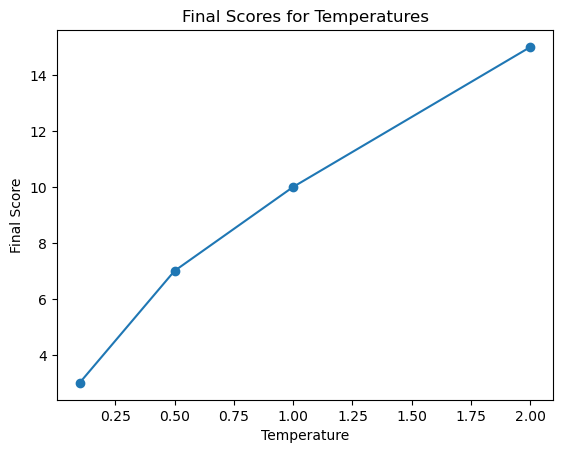

In [69]:
import matplotlib.pyplot as plt

results = evaluate_model_singular(base_model, num_removed, temperatures, experimental_data, threshold, 23)

# Extract final scores for the current seed
final_scores = []
for temp in temperatures:
    if results[temp]["history"]:  # Ensure history is not empty
        final_scores.append(results[temp]["history"][-1]['final_score'])
    else:
        print(f"Warning: No history for temperature {temp}")
        final_scores.append(None)  # Placeholder for missing data

# Filter out None values before plotting
filtered_temperatures = [t for t, score in zip(temperatures, final_scores) if score is not None]
filtered_scores = [score for score in final_scores if score is not None]

# Plot final scores for the current seed
plt.figure()
plt.plot(filtered_temperatures, filtered_scores, marker="o")
plt.xlabel("Temperature")
plt.ylabel("Final Score")
plt.title(f"Final Scores for Temperatures")
#plt.savefig(f"final_scores_seed_{seed}.png") 
plt.show()

In [53]:
results[0.1]['history']

[{'reaction': 'Random_Rxn_13',
  'final_score': 19.8096307123356,
  'fit_score': 18.8096307123356,
  'num_evals': 264},
 {'reaction': 'R5',
  'final_score': 32.38076908482351,
  'fit_score': 15.190384542411755,
  'num_evals': 517},
 {'reaction': 'Random_Rxn_18',
  'final_score': 48.57115352659155,
  'fit_score': 15.190384508863849,
  'num_evals': 759},
 {'reaction': 'Random_Rxn_10',
  'final_score': 4.0000002218842505,
  'fit_score': 5.547106267649217e-08,
  'num_evals': 990}]

r10
r9
[<Reaction Random_Rxn_1 at 0x16e792290>, <Reaction Random_Rxn_2 at 0x16e606a10>, <Reaction Random_Rxn_3 at 0x16e604490>, <Reaction Random_Rxn_4 at 0x16e5dbdd0>, <Reaction Random_Rxn_5 at 0x16e5fb790>, <Reaction Random_Rxn_6 at 0x16e6079d0>, <Reaction Random_Rxn_7 at 0x16e606150>, <Reaction Random_Rxn_8 at 0x16e606110>, <Reaction Random_Rxn_9 at 0x16e606f50>, <Reaction Random_Rxn_10 at 0x16e606610>, <Reaction Random_Rxn_11 at 0x16e607dd0>, <Reaction Random_Rxn_12 at 0x16e6065d0>, <Reaction Random_Rxn_13 at 0x16e5e1f10>, <Reaction Random_Rxn_14 at 0x16e5e1150>, <Reaction Random_Rxn_15 at 0x16e5e0510>, <Reaction Random_Rxn_16 at 0x16e605290>, <Reaction Random_Rxn_17 at 0x16e5e2e10>, <Reaction Random_Rxn_18 at 0x16e5e3390>, <Reaction Random_Rxn_19 at 0x16e5e3590>, <Reaction Random_Rxn_20 at 0x16e5e3050>, <Reaction Random_Rxn_21 at 0x16e5e3450>, <Reaction Random_Rxn_22 at 0x16e637290>, <Reaction Random_Rxn_23 at 0x16e635e10>, <Reaction Random_Rxn_24 at 0x16e637890>, <Reaction Random_

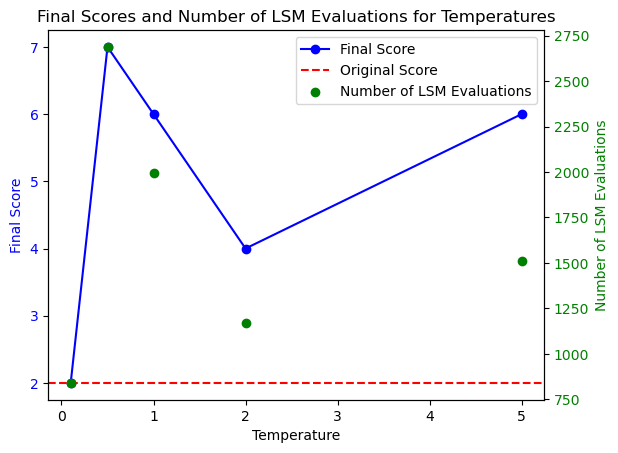

r7
r9
r8
[<Reaction Random_Rxn_1 at 0x2891e91d0>, <Reaction Random_Rxn_2 at 0x28914e4d0>, <Reaction Random_Rxn_3 at 0x2891e2810>, <Reaction Random_Rxn_4 at 0x2891e37d0>, <Reaction Random_Rxn_5 at 0x289166f50>, <Reaction Random_Rxn_6 at 0x28aab9810>, <Reaction Random_Rxn_7 at 0x2891e0a90>, <Reaction Random_Rxn_8 at 0x2891dbc10>, <Reaction Random_Rxn_9 at 0x28aa71010>, <Reaction Random_Rxn_10 at 0x28917ea10>, <Reaction Random_Rxn_11 at 0x28917f890>, <Reaction Random_Rxn_12 at 0x28917fed0>, <Reaction Random_Rxn_13 at 0x2892d0e50>, <Reaction Random_Rxn_14 at 0x28917d5d0>, <Reaction Random_Rxn_15 at 0x2892d3e90>, <Reaction Random_Rxn_16 at 0x2892d3ed0>, <Reaction Random_Rxn_17 at 0x2892d2190>, <Reaction Random_Rxn_18 at 0x28917ff50>, <Reaction Random_Rxn_19 at 0x2892d1d90>, <Reaction Random_Rxn_20 at 0x2892d22d0>, <Reaction Random_Rxn_21 at 0x2892d29d0>, <Reaction Random_Rxn_22 at 0x2892d2e50>, <Reaction Random_Rxn_23 at 0x2892d0510>, <Reaction Random_Rxn_24 at 0x2892d3e10>, <Reaction Rando

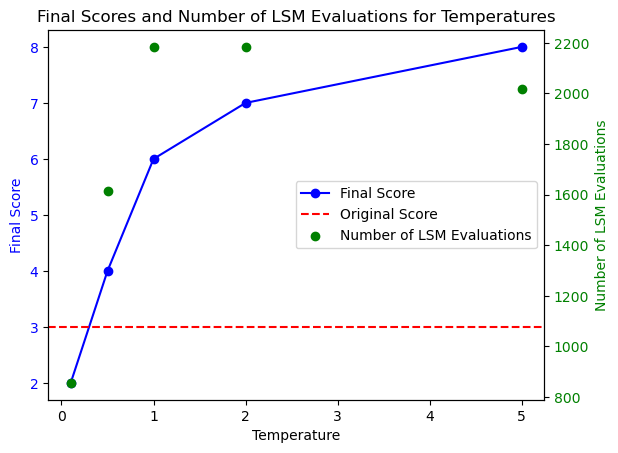

r9
r7
r5
r6
[<Reaction Random_Rxn_1 at 0x28b9530d0>, <Reaction Random_Rxn_2 at 0x28a803c50>, <Reaction Random_Rxn_3 at 0x28a8d3810>, <Reaction Random_Rxn_4 at 0x28a8c5450>, <Reaction Random_Rxn_5 at 0x28b9313d0>, <Reaction Random_Rxn_6 at 0x28a8b23d0>, <Reaction Random_Rxn_7 at 0x28a885e90>, <Reaction Random_Rxn_8 at 0x28a8b21d0>, <Reaction Random_Rxn_9 at 0x28a886610>, <Reaction Random_Rxn_10 at 0x28a886a90>, <Reaction Random_Rxn_11 at 0x28a886e10>, <Reaction Random_Rxn_12 at 0x28a887250>, <Reaction Random_Rxn_13 at 0x28a8876d0>, <Reaction Random_Rxn_14 at 0x28a886b10>, <Reaction Random_Rxn_15 at 0x28a887ed0>, <Reaction Random_Rxn_16 at 0x28a830510>, <Reaction Random_Rxn_17 at 0x28a830c90>, <Reaction Random_Rxn_18 at 0x28a887750>, <Reaction Random_Rxn_19 at 0x28a830390>, <Reaction Random_Rxn_20 at 0x28a831a10>, <Reaction Random_Rxn_21 at 0x28a831f90>, <Reaction Random_Rxn_22 at 0x28a831e90>, <Reaction Random_Rxn_23 at 0x28a832410>, <Reaction Random_Rxn_24 at 0x28a832890>, <Reaction Ra

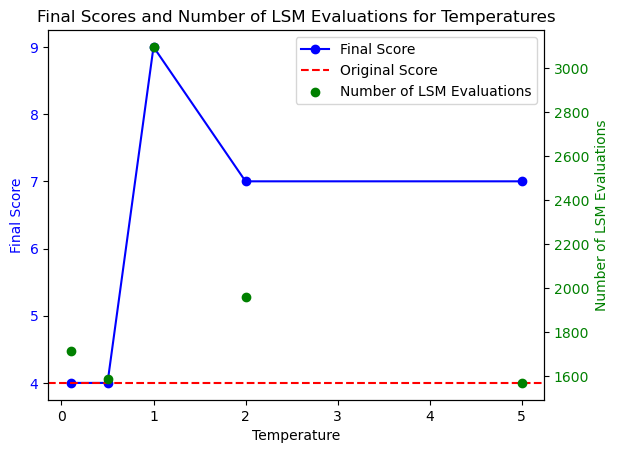

r10
r6
[<Reaction Random_Rxn_1 at 0x28a786b90>, <Reaction Random_Rxn_2 at 0x28a7c8a90>, <Reaction Random_Rxn_3 at 0x28a7313d0>, <Reaction Random_Rxn_4 at 0x28a741550>, <Reaction Random_Rxn_5 at 0x28a741450>, <Reaction Random_Rxn_6 at 0x28a7419d0>, <Reaction Random_Rxn_7 at 0x28a7322d0>, <Reaction Random_Rxn_8 at 0x28a742210>, <Reaction Random_Rxn_9 at 0x28a742690>, <Reaction Random_Rxn_10 at 0x28a742c10>, <Reaction Random_Rxn_11 at 0x28a743090>, <Reaction Random_Rxn_12 at 0x28a721010>, <Reaction Random_Rxn_13 at 0x28a743dd0>, <Reaction Random_Rxn_14 at 0x28a742710>, <Reaction Random_Rxn_15 at 0x28a743ad0>, <Reaction Random_Rxn_16 at 0x28bae0d90>, <Reaction Random_Rxn_17 at 0x28a742f90>, <Reaction Random_Rxn_18 at 0x28a3da9d0>, <Reaction Random_Rxn_19 at 0x28a7405d0>, <Reaction Random_Rxn_20 at 0x28a743550>, <Reaction Random_Rxn_21 at 0x28a7408d0>, <Reaction Random_Rxn_22 at 0x28bae1a90>, <Reaction Random_Rxn_23 at 0x28bae2490>, <Reaction Random_Rxn_24 at 0x28bae2a90>, <Reaction Random_

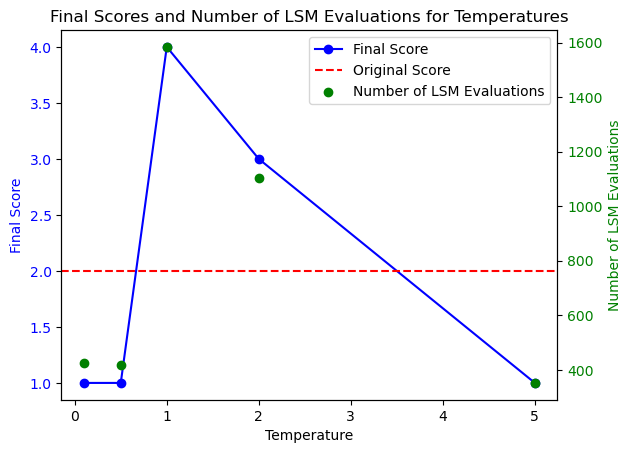

r7
r9
r5
[<Reaction Random_Rxn_1 at 0x28a18c490>, <Reaction Random_Rxn_2 at 0x28af96e90>, <Reaction Random_Rxn_3 at 0x28af97a10>, <Reaction Random_Rxn_4 at 0x28af97390>, <Reaction Random_Rxn_5 at 0x289136f50>, <Reaction Random_Rxn_6 at 0x289135290>, <Reaction Random_Rxn_7 at 0x16e5d6dd0>, <Reaction Random_Rxn_8 at 0x28af94590>, <Reaction Random_Rxn_9 at 0x16e5d77d0>, <Reaction Random_Rxn_10 at 0x289129010>, <Reaction Random_Rxn_11 at 0x16e5d76d0>, <Reaction Random_Rxn_12 at 0x28bb2f350>, <Reaction Random_Rxn_13 at 0x28bb2dd90>, <Reaction Random_Rxn_14 at 0x28bb2ea10>, <Reaction Random_Rxn_15 at 0x28bb2ffd0>, <Reaction Random_Rxn_16 at 0x28bb2ddd0>, <Reaction Random_Rxn_17 at 0x28bb2cd90>, <Reaction Random_Rxn_18 at 0x28bb2f6d0>, <Reaction Random_Rxn_19 at 0x16e5d7050>, <Reaction Random_Rxn_20 at 0x16e5d5390>, <Reaction Random_Rxn_21 at 0x28bb2f510>, <Reaction Random_Rxn_22 at 0x28bb2fe50>, <Reaction Random_Rxn_23 at 0x28bb2e610>, <Reaction Random_Rxn_24 at 0x28bb2c810>, <Reaction Rando

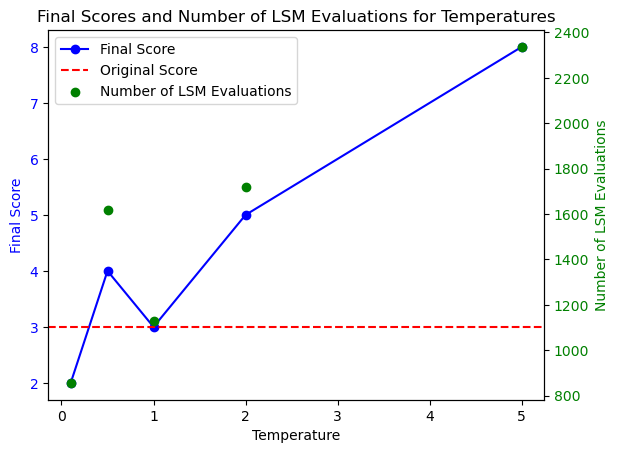

r8
r10
r7
r5
[<Reaction Random_Rxn_1 at 0x17a270410>, <Reaction Random_Rxn_2 at 0x14e82e550>, <Reaction Random_Rxn_3 at 0x17a7bbad0>, <Reaction Random_Rxn_4 at 0x179b9e690>, <Reaction Random_Rxn_5 at 0x17af8b950>, <Reaction Random_Rxn_6 at 0x14e82ebd0>, <Reaction Random_Rxn_7 at 0x28af2d7d0>, <Reaction Random_Rxn_8 at 0x14ea36bd0>, <Reaction Random_Rxn_9 at 0x28af2f790>, <Reaction Random_Rxn_10 at 0x28af2d9d0>, <Reaction Random_Rxn_11 at 0x28af2e810>, <Reaction Random_Rxn_12 at 0x28af2fb50>, <Reaction Random_Rxn_13 at 0x28af2c050>, <Reaction Random_Rxn_14 at 0x28af2f6d0>, <Reaction Random_Rxn_15 at 0x16e90a790>, <Reaction Random_Rxn_16 at 0x28af2f150>, <Reaction Random_Rxn_17 at 0x28af2e6d0>, <Reaction Random_Rxn_18 at 0x28af2cc90>, <Reaction Random_Rxn_19 at 0x28af3e050>, <Reaction Random_Rxn_20 at 0x28af2c710>, <Reaction Random_Rxn_21 at 0x28af3c690>, <Reaction Random_Rxn_22 at 0x28af3e590>, <Reaction Random_Rxn_23 at 0x28af3ce90>, <Reaction Random_Rxn_24 at 0x28af3f910>, <Reaction R

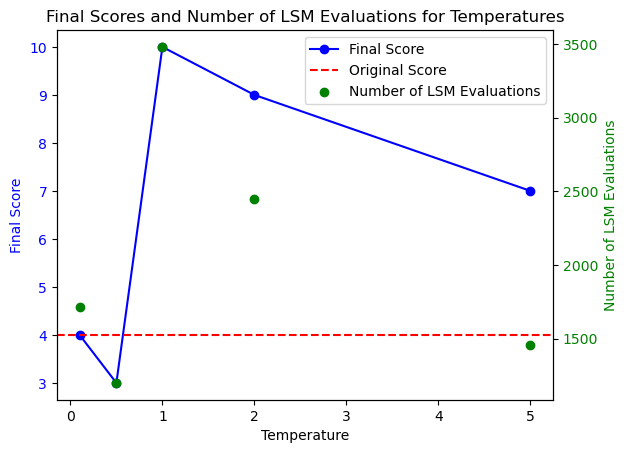

r7
r5
[<Reaction Random_Rxn_1 at 0x28bb61250>, <Reaction Random_Rxn_2 at 0x28bc05f90>, <Reaction Random_Rxn_3 at 0x28a230350>, <Reaction Random_Rxn_4 at 0x28a230190>, <Reaction Random_Rxn_5 at 0x28a230390>, <Reaction Random_Rxn_6 at 0x28a230250>, <Reaction Random_Rxn_7 at 0x28bb41b90>, <Reaction Random_Rxn_8 at 0x28a297a50>, <Reaction Random_Rxn_9 at 0x28a2974d0>, <Reaction Random_Rxn_10 at 0x28a2952d0>, <Reaction Random_Rxn_11 at 0x28bc77810>, <Reaction Random_Rxn_12 at 0x28a295150>, <Reaction Random_Rxn_13 at 0x28a296490>, <Reaction Random_Rxn_14 at 0x28a233110>, <Reaction Random_Rxn_15 at 0x28a233190>, <Reaction Random_Rxn_16 at 0x28a233390>, <Reaction Random_Rxn_17 at 0x28a294710>, <Reaction Random_Rxn_18 at 0x28a294290>, <Reaction Random_Rxn_19 at 0x28a294550>, <Reaction Random_Rxn_20 at 0x28a294dd0>, <Reaction Random_Rxn_21 at 0x28a295750>, <Reaction Random_Rxn_22 at 0x28a2f74d0>, <Reaction Random_Rxn_23 at 0x28a2f6b50>, <Reaction Random_Rxn_24 at 0x28a294210>, <Reaction Random_R

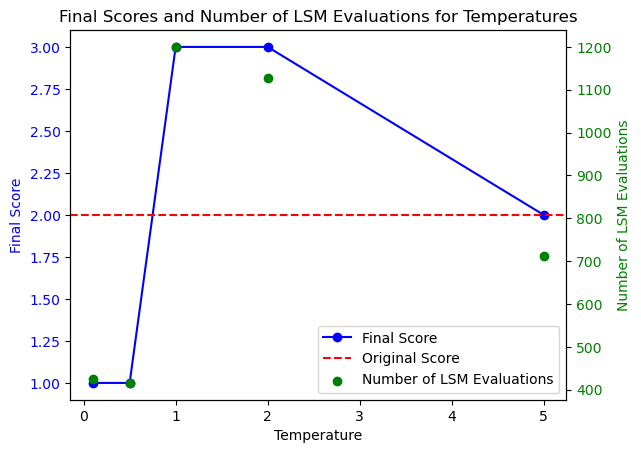

r9
r6
r10
[<Reaction Random_Rxn_1 at 0x28bcafd10>, <Reaction Random_Rxn_2 at 0x2897830d0>, <Reaction Random_Rxn_3 at 0x2897808d0>, <Reaction Random_Rxn_4 at 0x28bbd3d10>, <Reaction Random_Rxn_5 at 0x289780ed0>, <Reaction Random_Rxn_6 at 0x2893a3c10>, <Reaction Random_Rxn_7 at 0x28a710290>, <Reaction Random_Rxn_8 at 0x28bbd2210>, <Reaction Random_Rxn_9 at 0x28a5fd290>, <Reaction Random_Rxn_10 at 0x28a7124d0>, <Reaction Random_Rxn_11 at 0x28a711210>, <Reaction Random_Rxn_12 at 0x28a5fe650>, <Reaction Random_Rxn_13 at 0x28a5ff110>, <Reaction Random_Rxn_14 at 0x28a5ff450>, <Reaction Random_Rxn_15 at 0x28a5fe050>, <Reaction Random_Rxn_16 at 0x28a5fe710>, <Reaction Random_Rxn_17 at 0x28a5fd710>, <Reaction Random_Rxn_18 at 0x28a5fd410>, <Reaction Random_Rxn_19 at 0x28a5ffad0>, <Reaction Random_Rxn_20 at 0x28a5ff550>, <Reaction Random_Rxn_21 at 0x28a5fdb90>, <Reaction Random_Rxn_22 at 0x28a5ff2d0>, <Reaction Random_Rxn_23 at 0x28a5fca90>, <Reaction Random_Rxn_24 at 0x28a5ffa10>, <Reaction Rand

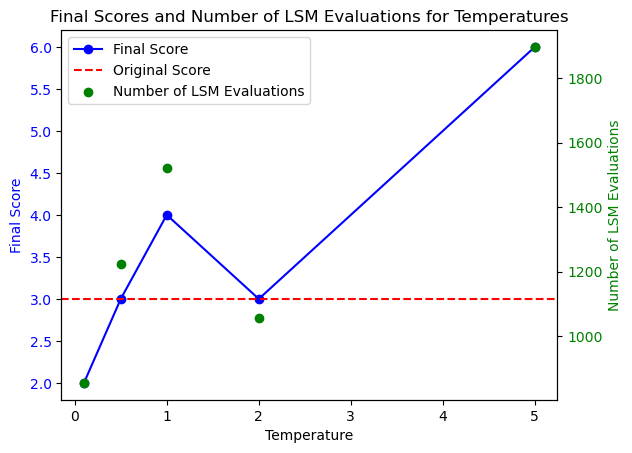

r7
r6
r8
r10
[<Reaction Random_Rxn_1 at 0x289557ad0>, <Reaction Random_Rxn_2 at 0x28af61650>, <Reaction Random_Rxn_3 at 0x28af62590>, <Reaction Random_Rxn_4 at 0x2896d1bd0>, <Reaction Random_Rxn_5 at 0x28a7e3310>, <Reaction Random_Rxn_6 at 0x28950c710>, <Reaction Random_Rxn_7 at 0x28a0fec90>, <Reaction Random_Rxn_8 at 0x17a795390>, <Reaction Random_Rxn_9 at 0x17a10a7d0>, <Reaction Random_Rxn_10 at 0x28b9daf90>, <Reaction Random_Rxn_11 at 0x2893ad510>, <Reaction Random_Rxn_12 at 0x2893ac710>, <Reaction Random_Rxn_13 at 0x2893acd10>, <Reaction Random_Rxn_14 at 0x2893af2d0>, <Reaction Random_Rxn_15 at 0x2893ac790>, <Reaction Random_Rxn_16 at 0x2893add10>, <Reaction Random_Rxn_17 at 0x2893aecd0>, <Reaction Random_Rxn_18 at 0x2893ac050>, <Reaction Random_Rxn_19 at 0x2893acbd0>, <Reaction Random_Rxn_20 at 0x2895d3c50>, <Reaction Random_Rxn_21 at 0x2893acad0>, <Reaction Random_Rxn_22 at 0x2893aca10>, <Reaction Random_Rxn_23 at 0x2893afdd0>, <Reaction Random_Rxn_24 at 0x2893ae8d0>, <Reaction R

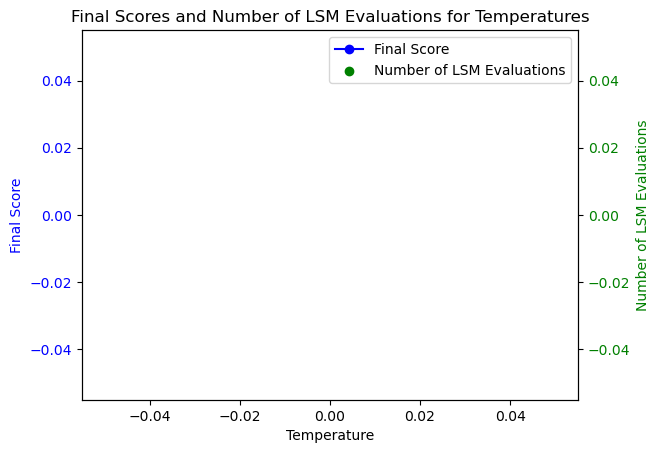

r8
r10
[<Reaction Random_Rxn_1 at 0x28a5a4710>, <Reaction Random_Rxn_2 at 0x28aa65650>, <Reaction Random_Rxn_3 at 0x2895b52d0>, <Reaction Random_Rxn_4 at 0x28a5ac910>, <Reaction Random_Rxn_5 at 0x28a5ad350>, <Reaction Random_Rxn_6 at 0x28a5aca50>, <Reaction Random_Rxn_7 at 0x28a5a7090>, <Reaction Random_Rxn_8 at 0x28a5e7c10>, <Reaction Random_Rxn_9 at 0x28a5e5810>, <Reaction Random_Rxn_10 at 0x28a5ac350>, <Reaction Random_Rxn_11 at 0x28a5e5590>, <Reaction Random_Rxn_12 at 0x28a5e4050>, <Reaction Random_Rxn_13 at 0x28a5e7fd0>, <Reaction Random_Rxn_14 at 0x28a5e6590>, <Reaction Random_Rxn_15 at 0x28a5e66d0>, <Reaction Random_Rxn_16 at 0x28a5e5c50>, <Reaction Random_Rxn_17 at 0x28a5e6410>, <Reaction Random_Rxn_18 at 0x28a5e4250>, <Reaction Random_Rxn_19 at 0x28a5adf50>, <Reaction Random_Rxn_20 at 0x28aaa64d0>, <Reaction Random_Rxn_21 at 0x28a5e2b50>, <Reaction Random_Rxn_22 at 0x28a5e60d0>, <Reaction Random_Rxn_23 at 0x28a5e76d0>, <Reaction Random_Rxn_24 at 0x28a5e5910>, <Reaction Random_

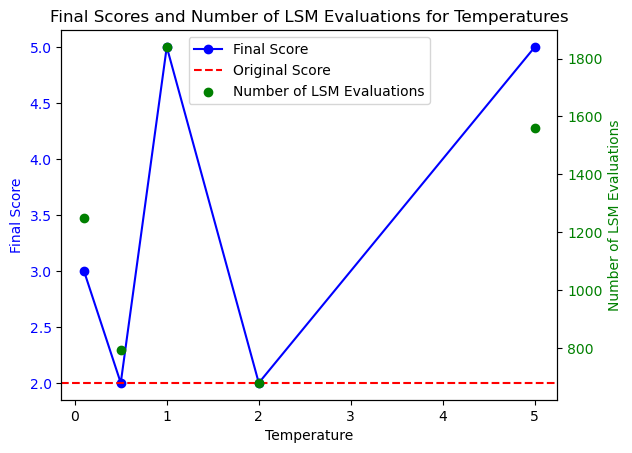

r6
r8
r5
[<Reaction Random_Rxn_1 at 0x2897d9d10>, <Reaction Random_Rxn_2 at 0x28a5d3490>, <Reaction Random_Rxn_3 at 0x2891ac3d0>, <Reaction Random_Rxn_4 at 0x2891ae6d0>, <Reaction Random_Rxn_5 at 0x14ea04450>, <Reaction Random_Rxn_6 at 0x14ea04110>, <Reaction Random_Rxn_7 at 0x2891e02d0>, <Reaction Random_Rxn_8 at 0x28abd4d50>, <Reaction Random_Rxn_9 at 0x14ea074d0>, <Reaction Random_Rxn_10 at 0x14ea04f90>, <Reaction Random_Rxn_11 at 0x14ea06ad0>, <Reaction Random_Rxn_12 at 0x14ea048d0>, <Reaction Random_Rxn_13 at 0x14ea04710>, <Reaction Random_Rxn_14 at 0x179fd7a50>, <Reaction Random_Rxn_15 at 0x14ea06410>, <Reaction Random_Rxn_16 at 0x16e651810>, <Reaction Random_Rxn_17 at 0x179fd6710>, <Reaction Random_Rxn_18 at 0x16e651150>, <Reaction Random_Rxn_19 at 0x14ea04150>, <Reaction Random_Rxn_20 at 0x16e650550>, <Reaction Random_Rxn_21 at 0x16e650f90>, <Reaction Random_Rxn_22 at 0x2895f96d0>, <Reaction Random_Rxn_23 at 0x2897da150>, <Reaction Random_Rxn_24 at 0x16e6505d0>, <Reaction Rando

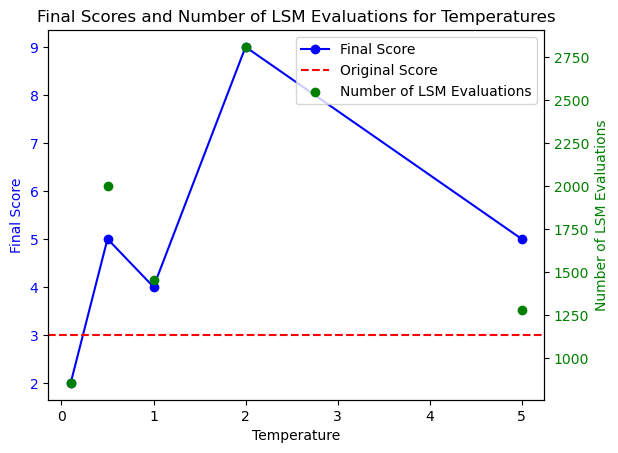

r10
r9
r7
r5
[<Reaction Random_Rxn_1 at 0x28a8ca750>, <Reaction Random_Rxn_2 at 0x28a1cbc50>, <Reaction Random_Rxn_3 at 0x28a2e8a90>, <Reaction Random_Rxn_4 at 0x28af60550>, <Reaction Random_Rxn_5 at 0x289311ed0>, <Reaction Random_Rxn_6 at 0x28af02a90>, <Reaction Random_Rxn_7 at 0x28af001d0>, <Reaction Random_Rxn_8 at 0x28bae0510>, <Reaction Random_Rxn_9 at 0x28bae03d0>, <Reaction Random_Rxn_10 at 0x28bae3cd0>, <Reaction Random_Rxn_11 at 0x28bae0e10>, <Reaction Random_Rxn_12 at 0x28bae2f50>, <Reaction Random_Rxn_13 at 0x28bae1590>, <Reaction Random_Rxn_14 at 0x28af9afd0>, <Reaction Random_Rxn_15 at 0x28bae1490>, <Reaction Random_Rxn_16 at 0x28bae1290>, <Reaction Random_Rxn_17 at 0x28bae3a50>, <Reaction Random_Rxn_18 at 0x28bae0050>, <Reaction Random_Rxn_19 at 0x28b9309d0>, <Reaction Random_Rxn_20 at 0x28b930090>, <Reaction Random_Rxn_21 at 0x28b932450>, <Reaction Random_Rxn_22 at 0x28b932d90>, <Reaction Random_Rxn_23 at 0x28b932290>, <Reaction Random_Rxn_24 at 0x28b930210>, <Reaction R

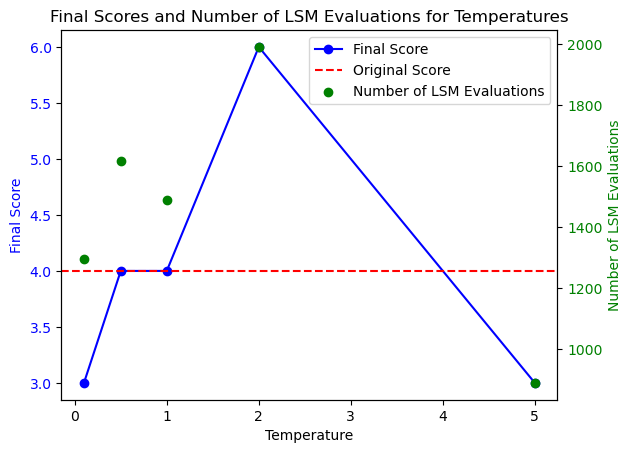

r5
r9
[<Reaction Random_Rxn_1 at 0x28979b0d0>, <Reaction Random_Rxn_2 at 0x28afecc50>, <Reaction Random_Rxn_3 at 0x28afec310>, <Reaction Random_Rxn_4 at 0x28afee190>, <Reaction Random_Rxn_5 at 0x28afeec10>, <Reaction Random_Rxn_6 at 0x28bb46b90>, <Reaction Random_Rxn_7 at 0x28afec4d0>, <Reaction Random_Rxn_8 at 0x28afec190>, <Reaction Random_Rxn_9 at 0x28afed710>, <Reaction Random_Rxn_10 at 0x28afed090>, <Reaction Random_Rxn_11 at 0x28bbe3f10>, <Reaction Random_Rxn_12 at 0x2897706d0>, <Reaction Random_Rxn_13 at 0x28bb44590>, <Reaction Random_Rxn_14 at 0x289798810>, <Reaction Random_Rxn_15 at 0x28979ab10>, <Reaction Random_Rxn_16 at 0x17a796910>, <Reaction Random_Rxn_17 at 0x28afedb10>, <Reaction Random_Rxn_18 at 0x28afee0d0>, <Reaction Random_Rxn_19 at 0x28afeeb10>, <Reaction Random_Rxn_20 at 0x28afecc90>, <Reaction Random_Rxn_21 at 0x28afeda50>, <Reaction Random_Rxn_22 at 0x17a7c7910>, <Reaction Random_Rxn_23 at 0x28afed250>, <Reaction Random_Rxn_24 at 0x17a7c70d0>, <Reaction Random_R

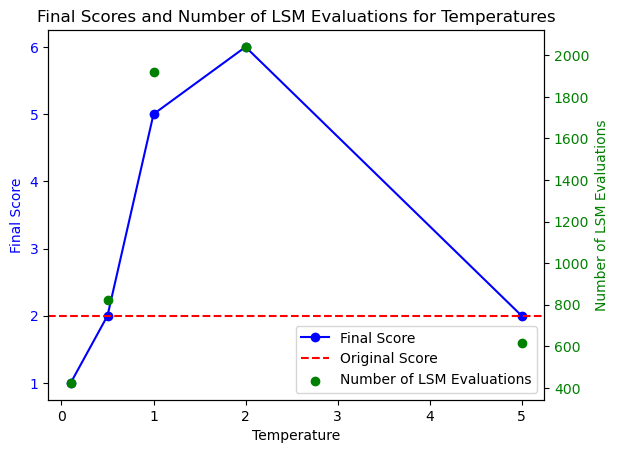

r8
r7
r10
[<Reaction Random_Rxn_1 at 0x28a008ed0>, <Reaction Random_Rxn_2 at 0x2aaa13c50>, <Reaction Random_Rxn_3 at 0x28a0882d0>, <Reaction Random_Rxn_4 at 0x289764750>, <Reaction Random_Rxn_5 at 0x289764510>, <Reaction Random_Rxn_6 at 0x289767010>, <Reaction Random_Rxn_7 at 0x2897f4e90>, <Reaction Random_Rxn_8 at 0x2892c4ed0>, <Reaction Random_Rxn_9 at 0x2892c4bd0>, <Reaction Random_Rxn_10 at 0x289765010>, <Reaction Random_Rxn_11 at 0x289764410>, <Reaction Random_Rxn_12 at 0x2897f7010>, <Reaction Random_Rxn_13 at 0x2897f75d0>, <Reaction Random_Rxn_14 at 0x28975c1d0>, <Reaction Random_Rxn_15 at 0x2892c54d0>, <Reaction Random_Rxn_16 at 0x289764d90>, <Reaction Random_Rxn_17 at 0x2892c6b50>, <Reaction Random_Rxn_18 at 0x2892c5c50>, <Reaction Random_Rxn_19 at 0x2892c6050>, <Reaction Random_Rxn_20 at 0x2892c7f90>, <Reaction Random_Rxn_21 at 0x2892c6390>, <Reaction Random_Rxn_22 at 0x2892c7d90>, <Reaction Random_Rxn_23 at 0x2892c7090>, <Reaction Random_Rxn_24 at 0x2892c4b90>, <Reaction Rand

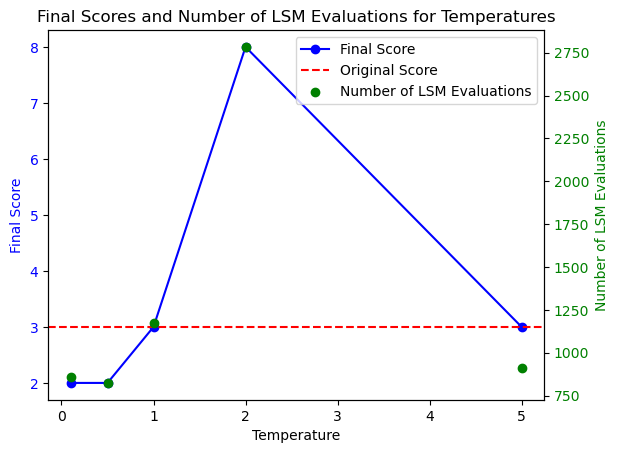

r9
r6
r8
r10
[<Reaction Random_Rxn_1 at 0x28973e690>, <Reaction Random_Rxn_2 at 0x2891aedd0>, <Reaction Random_Rxn_3 at 0x28a1b9fd0>, <Reaction Random_Rxn_4 at 0x2892d8a50>, <Reaction Random_Rxn_5 at 0x28973cc50>, <Reaction Random_Rxn_6 at 0x2892d9090>, <Reaction Random_Rxn_7 at 0x2892d9b50>, <Reaction Random_Rxn_8 at 0x2892da6d0>, <Reaction Random_Rxn_9 at 0x2892da7d0>, <Reaction Random_Rxn_10 at 0x2892d9ad0>, <Reaction Random_Rxn_11 at 0x2892d9510>, <Reaction Random_Rxn_12 at 0x2892db950>, <Reaction Random_Rxn_13 at 0x2892d9a50>, <Reaction Random_Rxn_14 at 0x2892da5d0>, <Reaction Random_Rxn_15 at 0x2892d8cd0>, <Reaction Random_Rxn_16 at 0x2892db0d0>, <Reaction Random_Rxn_17 at 0x28a5449d0>, <Reaction Random_Rxn_18 at 0x28afff190>, <Reaction Random_Rxn_19 at 0x28a04dc90>, <Reaction Random_Rxn_20 at 0x2892db190>, <Reaction Random_Rxn_21 at 0x2892db8d0>, <Reaction Random_Rxn_22 at 0x2892d9010>, <Reaction Random_Rxn_23 at 0x28a545d90>, <Reaction Random_Rxn_24 at 0x2892da190>, <Reaction R

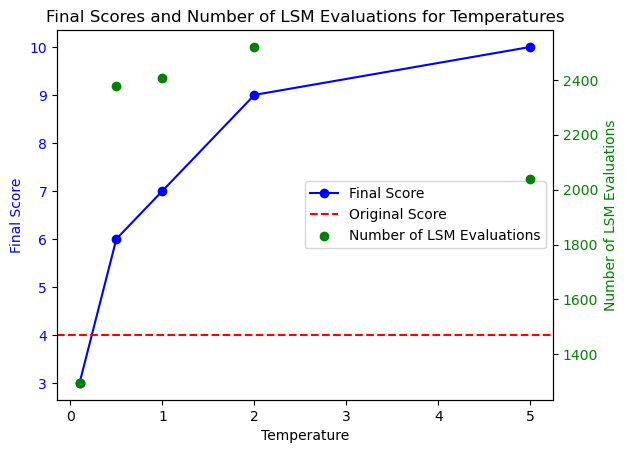

r10
r9
[<Reaction Random_Rxn_1 at 0x28a69b550>, <Reaction Random_Rxn_2 at 0x28977d2d0>, <Reaction Random_Rxn_3 at 0x2892c7b90>, <Reaction Random_Rxn_4 at 0x2892c6c10>, <Reaction Random_Rxn_5 at 0x28bc43c90>, <Reaction Random_Rxn_6 at 0x28a597ad0>, <Reaction Random_Rxn_7 at 0x28bbc0590>, <Reaction Random_Rxn_8 at 0x28af0da90>, <Reaction Random_Rxn_9 at 0x28936a510>, <Reaction Random_Rxn_10 at 0x28bbc3f50>, <Reaction Random_Rxn_11 at 0x28afffa90>, <Reaction Random_Rxn_12 at 0x28aaa5910>, <Reaction Random_Rxn_13 at 0x28aaa7d90>, <Reaction Random_Rxn_14 at 0x28aaa4610>, <Reaction Random_Rxn_15 at 0x28afe5b90>, <Reaction Random_Rxn_16 at 0x28aaa6190>, <Reaction Random_Rxn_17 at 0x176e7b550>, <Reaction Random_Rxn_18 at 0x176e79650>, <Reaction Random_Rxn_19 at 0x176e7b250>, <Reaction Random_Rxn_20 at 0x176e78f90>, <Reaction Random_Rxn_21 at 0x28a5416d0>, <Reaction Random_Rxn_22 at 0x28a540dd0>, <Reaction Random_Rxn_23 at 0x28a540c50>, <Reaction Random_Rxn_24 at 0x28a540050>, <Reaction Random_

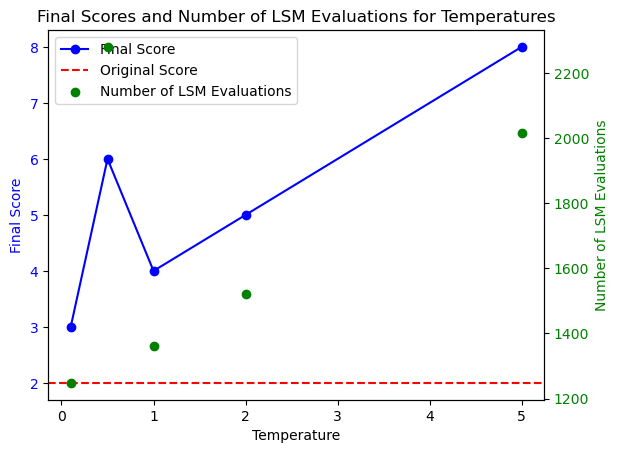

r8
r5
r6
[<Reaction Random_Rxn_1 at 0x28bbf7ad0>, <Reaction Random_Rxn_2 at 0x28b9c82d0>, <Reaction Random_Rxn_3 at 0x28a210250>, <Reaction Random_Rxn_4 at 0x28aafe090>, <Reaction Random_Rxn_5 at 0x28b9cb290>, <Reaction Random_Rxn_6 at 0x28a211d10>, <Reaction Random_Rxn_7 at 0x28a211710>, <Reaction Random_Rxn_8 at 0x28a210ed0>, <Reaction Random_Rxn_9 at 0x28a2139d0>, <Reaction Random_Rxn_10 at 0x28a210d50>, <Reaction Random_Rxn_11 at 0x28a2112d0>, <Reaction Random_Rxn_12 at 0x28bc56890>, <Reaction Random_Rxn_13 at 0x28a212cd0>, <Reaction Random_Rxn_14 at 0x28a212810>, <Reaction Random_Rxn_15 at 0x28bc56b10>, <Reaction Random_Rxn_16 at 0x28bc57a50>, <Reaction Random_Rxn_17 at 0x28bc54650>, <Reaction Random_Rxn_18 at 0x28bc54090>, <Reaction Random_Rxn_19 at 0x28bc54ad0>, <Reaction Random_Rxn_20 at 0x28bc56590>, <Reaction Random_Rxn_21 at 0x28bc57590>, <Reaction Random_Rxn_22 at 0x28bc55390>, <Reaction Random_Rxn_23 at 0x28a213310>, <Reaction Random_Rxn_24 at 0x28a213690>, <Reaction Rando

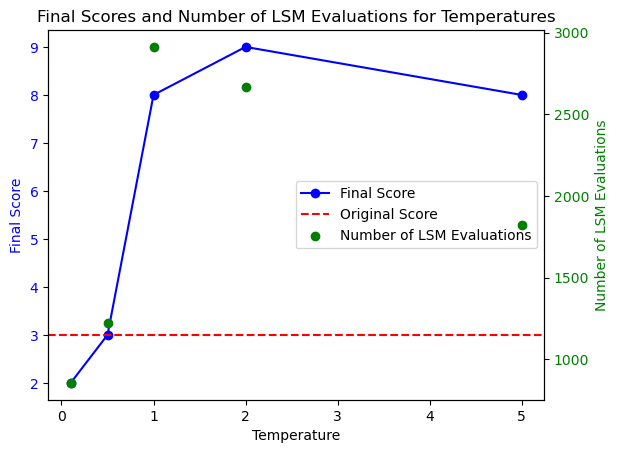

r8
r7
r10
r6
[<Reaction Random_Rxn_1 at 0x28a659dd0>, <Reaction Random_Rxn_2 at 0x28a857c50>, <Reaction Random_Rxn_3 at 0x28a857090>, <Reaction Random_Rxn_4 at 0x28a855d90>, <Reaction Random_Rxn_5 at 0x28975e610>, <Reaction Random_Rxn_6 at 0x28975f0d0>, <Reaction Random_Rxn_7 at 0x28a829690>, <Reaction Random_Rxn_8 at 0x28975c710>, <Reaction Random_Rxn_9 at 0x28baa1710>, <Reaction Random_Rxn_10 at 0x28975c5d0>, <Reaction Random_Rxn_11 at 0x28975ed90>, <Reaction Random_Rxn_12 at 0x28975e910>, <Reaction Random_Rxn_13 at 0x28a857290>, <Reaction Random_Rxn_14 at 0x28ba21890>, <Reaction Random_Rxn_15 at 0x28a655890>, <Reaction Random_Rxn_16 at 0x2892d9790>, <Reaction Random_Rxn_17 at 0x28a407890>, <Reaction Random_Rxn_18 at 0x28975e310>, <Reaction Random_Rxn_19 at 0x28975d1d0>, <Reaction Random_Rxn_20 at 0x2892db650>, <Reaction Random_Rxn_21 at 0x289701090>, <Reaction Random_Rxn_22 at 0x28a857450>, <Reaction Random_Rxn_23 at 0x28975d110>, <Reaction Random_Rxn_24 at 0x2897005d0>, <Reaction R

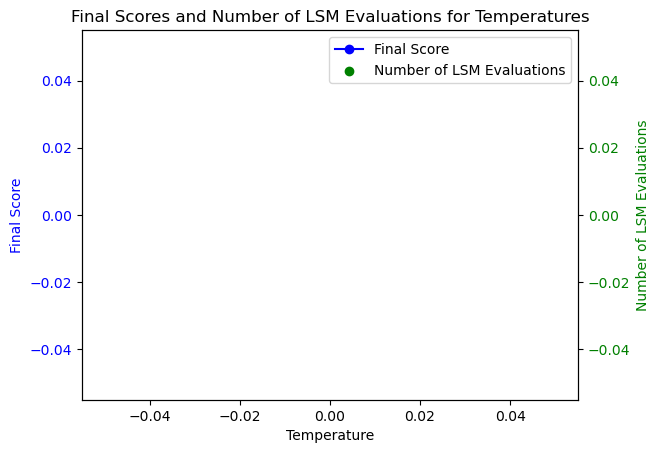

r8
r5
[<Reaction Random_Rxn_1 at 0x28a401010>, <Reaction Random_Rxn_2 at 0x28a013550>, <Reaction Random_Rxn_3 at 0x289137b90>, <Reaction Random_Rxn_4 at 0x28aa2d210>, <Reaction Random_Rxn_5 at 0x28a010e10>, <Reaction Random_Rxn_6 at 0x2896af2d0>, <Reaction Random_Rxn_7 at 0x28a0120d0>, <Reaction Random_Rxn_8 at 0x28a011910>, <Reaction Random_Rxn_9 at 0x28af52ad0>, <Reaction Random_Rxn_10 at 0x28a012410>, <Reaction Random_Rxn_11 at 0x28af52dd0>, <Reaction Random_Rxn_12 at 0x28af52c10>, <Reaction Random_Rxn_13 at 0x28a010cd0>, <Reaction Random_Rxn_14 at 0x28af536d0>, <Reaction Random_Rxn_15 at 0x28a010850>, <Reaction Random_Rxn_16 at 0x28af53a50>, <Reaction Random_Rxn_17 at 0x28af51b90>, <Reaction Random_Rxn_18 at 0x28af52290>, <Reaction Random_Rxn_19 at 0x28af53bd0>, <Reaction Random_Rxn_20 at 0x28a011410>, <Reaction Random_Rxn_21 at 0x28a011510>, <Reaction Random_Rxn_22 at 0x2896afe50>, <Reaction Random_Rxn_23 at 0x28af51d50>, <Reaction Random_Rxn_24 at 0x28aa55dd0>, <Reaction Random_R

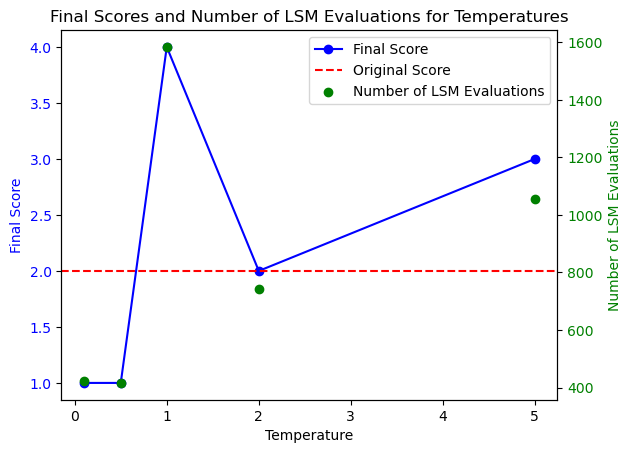

r6
r5
r10
[<Reaction Random_Rxn_1 at 0x16e606b90>, <Reaction Random_Rxn_2 at 0x289126e50>, <Reaction Random_Rxn_3 at 0x28a82bdd0>, <Reaction Random_Rxn_4 at 0x289127d10>, <Reaction Random_Rxn_5 at 0x179eda910>, <Reaction Random_Rxn_6 at 0x179edbc10>, <Reaction Random_Rxn_7 at 0x179ed86d0>, <Reaction Random_Rxn_8 at 0x179ed9c10>, <Reaction Random_Rxn_9 at 0x179ed8590>, <Reaction Random_Rxn_10 at 0x179edb990>, <Reaction Random_Rxn_11 at 0x179ed8290>, <Reaction Random_Rxn_12 at 0x2891379d0>, <Reaction Random_Rxn_13 at 0x179ed8110>, <Reaction Random_Rxn_14 at 0x179edb9d0>, <Reaction Random_Rxn_15 at 0x2896af9d0>, <Reaction Random_Rxn_16 at 0x2896ae550>, <Reaction Random_Rxn_17 at 0x179edabd0>, <Reaction Random_Rxn_18 at 0x28bc07b10>, <Reaction Random_Rxn_19 at 0x289127ad0>, <Reaction Random_Rxn_20 at 0x16e605150>, <Reaction Random_Rxn_21 at 0x2896adf90>, <Reaction Random_Rxn_22 at 0x179ed9f50>, <Reaction Random_Rxn_23 at 0x2896afb90>, <Reaction Random_Rxn_24 at 0x28ba21150>, <Reaction Rand

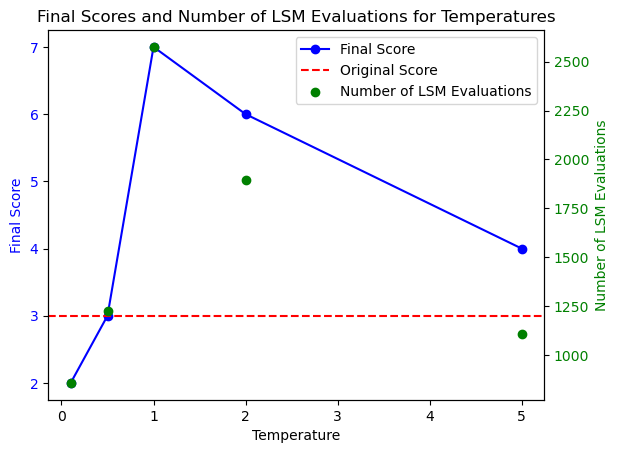

r5
r9
r8
r7
[<Reaction Random_Rxn_1 at 0x16e6346d0>, <Reaction Random_Rxn_2 at 0x28a799e50>, <Reaction Random_Rxn_3 at 0x28aa082d0>, <Reaction Random_Rxn_4 at 0x289622290>, <Reaction Random_Rxn_5 at 0x289623b50>, <Reaction Random_Rxn_6 at 0x289622790>, <Reaction Random_Rxn_7 at 0x14e82d910>, <Reaction Random_Rxn_8 at 0x2896235d0>, <Reaction Random_Rxn_9 at 0x289622e50>, <Reaction Random_Rxn_10 at 0x17ff99fd0>, <Reaction Random_Rxn_11 at 0x28bb6a290>, <Reaction Random_Rxn_12 at 0x28aa0e410>, <Reaction Random_Rxn_13 at 0x14e82f310>, <Reaction Random_Rxn_14 at 0x14e82f9d0>, <Reaction Random_Rxn_15 at 0x14e82e6d0>, <Reaction Random_Rxn_16 at 0x28bba5ed0>, <Reaction Random_Rxn_17 at 0x14e82ff90>, <Reaction Random_Rxn_18 at 0x14e82e790>, <Reaction Random_Rxn_19 at 0x14e82f990>, <Reaction Random_Rxn_20 at 0x28bbf7a10>, <Reaction Random_Rxn_21 at 0x28bbf7cd0>, <Reaction Random_Rxn_22 at 0x28bbf5150>, <Reaction Random_Rxn_23 at 0x28bbf7190>, <Reaction Random_Rxn_24 at 0x14e82ccd0>, <Reaction Ra

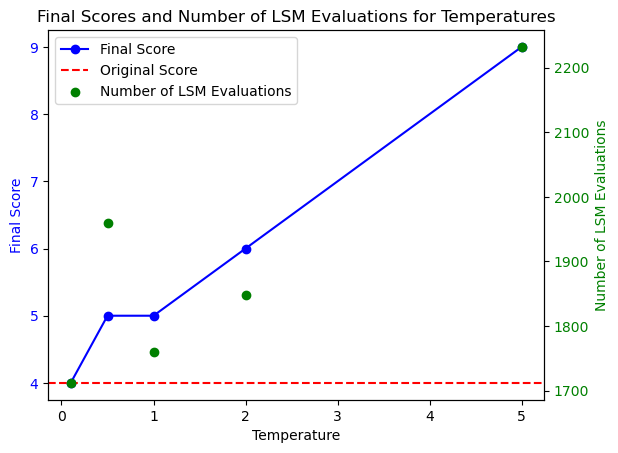

In [21]:
import matplotlib.pyplot as plt

for seed in seeds:
    for num_removed in num_removed_list:
        results = evaluate_model_singular(base_model, num_removed, temperatures, experimental_data, threshold, seed=seed)

        # Extract final scores for the current seed
        final_scores = []
        original_score = None
        num_evals = []
        for temp in temperatures:
            if results[temp]["history"]:  # Ensure history is not empty
                final_scores.append(results[temp]["history"][-1]['final_score'])
                num_evals.append(results[temp]["history"][-1]['num_evals'])
                original_score = results[temp]["original_score"]
            else:
                print(f"Warning: No history for temperature {temp}")
                final_scores.append(None)  # Placeholder for missing data

        # Filter out None values before plotting
        filtered_temperatures = [t for t, score in zip(temperatures, final_scores) if score is not None]
        filtered_scores = [score for score in final_scores if score is not None]
        filtered_num_evals = [evals for evals, score in zip(num_evals, final_scores) if score is not None]

        # Plot final scores for the current seed
        fig, ax1 = plt.subplots()

        # Primary y-axis: Final scores
        ax1.plot(filtered_temperatures, filtered_scores, marker="o", color="b", label="Final Score")
        ax1.set_xlabel("Temperature")
        ax1.set_ylabel("Final Score", color="b")
        ax1.tick_params(axis='y', labelcolor="b")
        ax1.set_title(f"Final Scores and Number of LSM Evaluations for Temperatures")

        # Add original score as a horizontal line
        if original_score:
            ax1.axhline(y=original_score, color='r', linestyle='--', label="Original Score")

        # Secondary y-axis: Number of evaluations
        ax2 = ax1.twinx()
        ax2.scatter(filtered_temperatures, filtered_num_evals, color="g", label="Number of LSM Evaluations")
        ax2.set_ylabel("Number of LSM Evaluations", color="g")
        ax2.tick_params(axis='y', labelcolor="g")

        # Combine legends from both axes
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

        # Save or display the plot
        plt.savefig(f"final_scores_seed_{num_removed}_{seed}_SK.png")
        plt.show()


In [26]:
# Method to run the workflow for a single model with varying parameters
def evaluate_model(base_model, num_removed_list, temperatures, experimental_data, threshold=3e-7):
    
    results = {}

    for num_removed in num_removed_list:
        for i in range(3):  # Generate three models for each num_removed
            # Create input model and random reaction pool
            original_model = base_model.copy()
            input_model, reaction_list = reduce_model_random(original_model, num_removed)

            for temperature in temperatures:
                print(f"Evaluating num_removed={num_removed}, temperature={temperature}, iteration={i+1}")

                # Run reconstruction
                final_model, history, original_score = reconstruct_model(
                    input_model, original_model, reaction_list, experimental_data, threshold, temperature
                )

                # Save results
                results[(num_removed, temperature, i)] = {
                    "final_model": final_model,
                    "history": history,
                    "original_score": original_score
                }

    return results

In [27]:
num_removed_list = [1, 2, 3, 4]  
temperatures = [0.1, 0.5, 1.0, 2.0] 

In [28]:
random.seed(42)
np.random.seed(42)

In [29]:
results42 = evaluate_model(model, num_removed_list, temperatures, experimental_data_zeropadded_out)

R11
Evaluating num_removed=1, temperature=0.1, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=0.5, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=1.0, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=2.0, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
R13
Evaluating num_removed=1, temperature=0.1, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=0.5, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=1.0, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=2.0, iteration=2
1.000000070848584
Reaction list is empty. Stopping reconstruction.
R10
Evaluating num_removed=1, temperature=0.1, iter

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Iteration limit reached
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Threshold reached. Reconstruction complete.
Evaluating num_removed=3, temperature=0.5, iteration=3
3.0000002125457526
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in L

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Threshold reached. Reconstruction complete.
Evaluating num_removed=4, temperature=0.5, iteration=1
4.000000283394336
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LS

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

In [30]:
random.seed(17)
np.random.seed(17)

In [31]:
results17 = evaluate_model(model, num_removed_list, temperatures, experimental_data_zeropadded_out)

R9
Evaluating num_removed=1, temperature=0.1, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=0.5, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=1.0, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=2.0, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
R7
Evaluating num_removed=1, temperature=0.1, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=0.5, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=1.0, iteration=2
1.000000070848584
Reaction list is empty. Stopping reconstruction.
Evaluating num_removed=1, temperature=2.0, iteration=2
1.000000070848584
Reaction list is empty. Stopping reconstruction.
R7
Evaluating num_removed=1, temperature=0.1, it

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Threshold reached. Reconstruction complete.
Evaluating num_removed=2, temperature=1.0, iteration=1
2.000000141697168
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LS

2.000000141697168
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschl

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Reaction list is empty. Stopping reconstruction.
R6
R7
Evaluating num_removed=2, temperature=0.1, iteration=3
2.000000141697168
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Threshold reached. Reconstruction complete.
Evaluating num_removed=2, temperature=1.0, iteration=3
2.000000141697168
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints 

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

4.000000283394336
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschl

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

/Users/philipp/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Iteration limit reached
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Iteration limit reached
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem


Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

In [32]:
results17[(4, 1.0, 2)]["history"]

[{'reaction': 'Random_Rxn_16',
  'final_score': 1.0,
  'fit_score': 0.0,
  'num_evals': 44},
 {'reaction': 'Random_Rxn_1',
  'final_score': 2.0,
  'fit_score': 0.0,
  'num_evals': 77},
 {'reaction': 'Random_Rxn_9',
  'final_score': 3.0,
  'fit_score': 0.0,
  'num_evals': 99}]

In [33]:
results_list = [results42, results17]

In [34]:
import matplotlib.pyplot as plt

In [35]:
def plot_average_num_evals_multiple(results_list, temperatures):
 
    avg_num_evals = {temp: [] for temp in temperatures}

    for results in results_list:
        for (num_removed, temperature, iteration), result in results.items():
            history = result["history"]
            if history:
                avg_num_evals[temperature].append(history[-1]["num_evals"])

    avg_values = {temp: np.mean(avg_num_evals[temp]) for temp in temperatures}

    plt.figure()
    plt.bar(range(len(avg_values)), avg_values.values(), tick_label=[str(temp) for temp in avg_values.keys()])
    plt.xlabel("Temperature")
    plt.ylabel("Average num_evals")
    plt.title("Average num_evals vs. Temperature (Multiple Results)")
    plt.show()


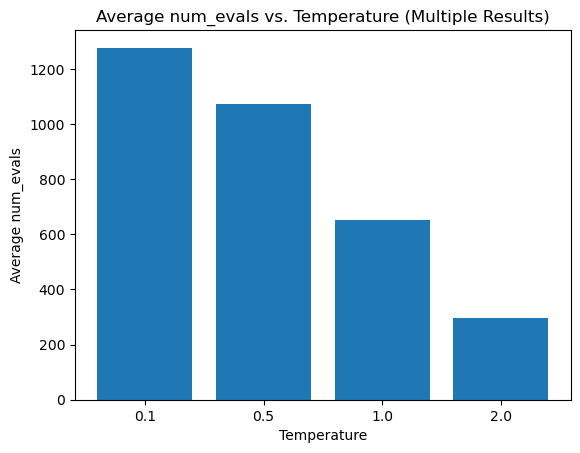

In [36]:
plot_average_num_evals_multiple(results_list, temperatures)

In [37]:
def plot_models_reaching_threshold(results, temperatures, threshold):
   
    models_reaching_threshold = {temp: 0 for temp in temperatures}

    for (num_removed, temperature, iteration), result in results.items():
        history = result["history"]
        if history and history[-1]["fit_score"] < threshold:
            models_reaching_threshold[temperature] += 1

    plt.figure()
    plt.bar(range(len(models_reaching_threshold)), models_reaching_threshold.values(), tick_label=[str(temp) for temp in models_reaching_threshold.keys()])
    plt.xlabel("Temperature")
    plt.ylabel("Number of Models")
    plt.title("Models Reaching Threshold vs. Temperature")
    plt.show()

In [38]:
def plot_models_reaching_threshold_multiple(results_list, temperatures, threshold):
   
    models_reaching_threshold = {temp: 0 for temp in temperatures}

    for results in results_list:
        for (num_removed, temperature, iteration), result in results.items():
            history = result["history"]
            if history and history[-1]["fit_score"] < threshold:
                models_reaching_threshold[temperature] += 1

    plt.figure()
    plt.bar(range(len(models_reaching_threshold)), models_reaching_threshold.values(), tick_label=[str(temp) for temp in models_reaching_threshold.keys()])
    plt.xlabel("Temperature")
    plt.ylabel("Number of Models")
    plt.title("Models Reaching Threshold vs. Temperature (Multiple Results)")
    plt.show()


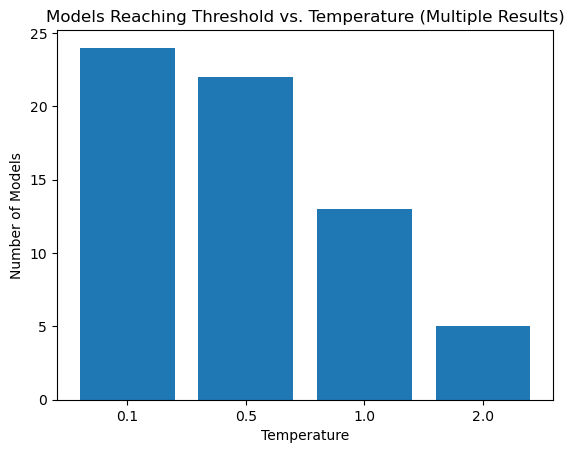

In [39]:
plot_models_reaching_threshold_multiple(results_list, temperatures, threshold)

In [40]:
def plot_final_scores_multiple(results_list, temperatures):
   
    final_scores = {temp: [] for temp in temperatures}

    for results in results_list:
        for (num_removed, temperature, iteration), result in results.items():
            history = result["history"]
            if history:
                final_scores[temperature].append(history[-1]["final_score"])

    plt.figure()
    for temp, scores in final_scores.items():
        plt.scatter([temp] * len(scores), scores, label=f"Temp={temp}")

    plt.xlabel("Temperature")
    plt.ylabel("Final Scores")
    plt.title("Final Scores vs. Temperature")
    plt.legend()
    plt.show()


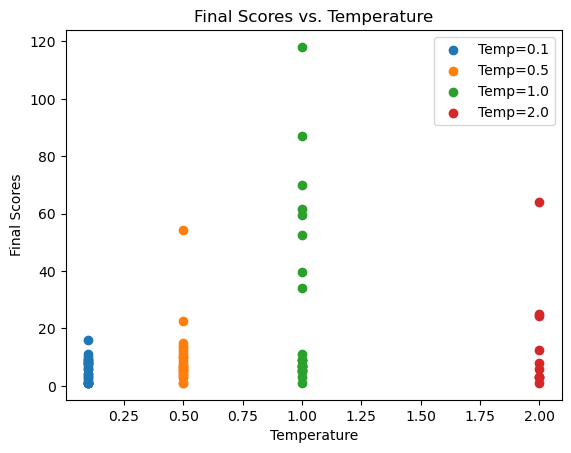

In [41]:
plot_final_scores_multiple(results_list, temperatures)